We first import the required packages.

In [24]:
# import packages
import os
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns
import urllib.request
# from openpyxl import load_workbook
from scipy import optimize

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 100)

PLOT_PATH = 'plots'
HIST_PATH = 'data/historic'
ECON_PATH = 'data/economic'
PLOT_PARAMS = {
    'palette': ['#58D68D', '#E74C3C', '#D35400', '#34495E']
}

We read in the datasets. They are as follows:
- df_prices_m: Monthly prices of the following ticks
TLT, BAR, SCHR, UST, EWJ, PDBC, IEMG, VGK, SCHP, GXC, DBC, SCHB, VEA, IEMG, VWO, SCHE, GLD, VTI, ITE, TIP, VTV, VOE, VBR

- df_prices_d: Daily returns of the following assets

PERMNO is a unique stock (share class) level identifier assigned by CRSP in the CRSP dataset.
DATE is the the date from which historic returns are available.
COMNAM is the name of the asset.
PERMNO    TICKER          DATE    COMNAM                              TICKER

16861    BAR         20170831    GRANITESHARES GOLD TRUST            BAR     
91129    DBC         20180604    INVESCO D B COMM IDX TRK FD         DBC     
83225    EWJ         20000522    ISHARES INC                         EWJ     
90448    GLD         20080521    SPDR GOLD TRUST                     GLD     
91878    GXC         20070801    SPDR INDEX SHARES FUNDS             GXC     
13613    IEMG        20121022    ISHARES INC                         IEMG    
92026    ITE         20070801    SPDR SERIES TRUST                   ITE     
15076    PDBC        20180604    INVESCO ACT MANAGED E T COMM FD     PDBC    
93112    SCHB        20091103    SCHWAB STRATEGIC TRUST              SCHB    
93219    SCHE        20100114    SCHWAB STRATEGIC TRUST              SCHE    
12065    SCHP        20100806    SCHWAB STRATEGIC TRUST              SCHP    
12059    SCHR        20100806    SCHWAB STRATEGIC TRUST              SCHR    
89959    TIP         20031205    ISHARES TRUST                       TIP     
89468    TLT         20020726    ISHARES TRUST                       TLT     
93218    UST         20100121    PROSHARES TRUST                     UST     
90000    VBR         20040130    VANGUARD INDEX FUNDS                VBR     
92187    VEA         20070726    VANGUARD TAX MANAGED FUNDS          VEA     
91132    VGK         20050310    VANGUARD INTL EQUITY INDEX FUNDS    VGK     
91423    VOE         20060824    VANGUARD INDEX FUNDS                VOE     
90878    VTI         20010531    VANGUARD INDEX FUNDS                VTI     
90004    VTV         20040130    VANGUARD INDEX FUNDS                VTV     
91130    VWO         20050310    VANGUARD INTL EQUITY INDEX FUNDS    VWO     


- df_econ: Monthly macro data
    - LIBOR: 1-Month London Interbank Offered Rate (LIBOR), based on U.S. Dollar (USD1MTD156N)
    <https://fred.stlouisfed.org/series/USD1MTD156N>
    - CPI: Consumer Price Index for All Urban Consumers: All Items (CPIAUCSL)
    <https://fred.stlouisfed.org/series/CPIAUCSL>
    - IR: Interest Rates, Discount Rate for United States (INTDSRUSM193N)
    <https://fred.stlouisfed.org/series/INTDSRUSM193N?utm_source=series_page&utm_medium=related_content&utm_term=related_resources&utm_campaign=categories>
    - UNEMP: Unemployment Rate: Aged 15-64: All Persons for the United States (LRUN64TTUSM156S)
    <https://fred.stlouisfed.org/series/LRUN64TTUSM156S>
    - MR: 30-Year Fixed Rate Mortgage Average in the United States (MORTGAGE30US)
    <https://fred.stlouisfed.org/series/MORTGAGE30US>
    - HPI: S&P/Case-Shiller U.S. National Home Price Index (CSUSHPISA)
    <https://fred.stlouisfed.org/series/CSUSHPISA>
    - rGDP: Real Gross Domestic Product (GDPC1)
    <https://fred.stlouisfed.org/series/GDPC1>



In [29]:
############################################################
# Read data
############################################################
# macro data
df_econ = pd.read_csv(os.path.join(ECON_PATH, 'agg_nonindexed.csv'),
                      parse_dates=['DATE'])
df_econ['DATE'] = df_econ['DATE'].dt.to_period('m')
df_econ.set_index('DATE', inplace=True)

# monthly prices
df_prices_m = pd.read_csv(os.path.join(HIST_PATH, 'ticks_M.csv'),
                        parse_dates=['DATE'])
df_prices_m['DATE'] = df_prices_m['DATE'].dt.to_period('m')
df_prices_m.set_index('DATE', inplace=True)

# daily prices
df_prices_d = pd.read_csv(os.path.join(HIST_PATH, 'rets_D.csv'),
                        parse_dates=['DATE'])
df_prices_d['DATE'] = df_prices_d['DATE'].dt.to_period('d')
df_prices_d.set_index('DATE', inplace=True)

In [26]:
############################################################
# Risk contribution
############################################################
def pct_risk_contribution(allocs, cov_rtns):
    portfolio_vol = np.sqrt(np.dot(np.dot(allocs, cov_rtns), allocs))
    return np.multiply(allocs, np.dot(cov_rtns, allocs)) / (portfolio_vol ** 2)
    
def risk_contribution_diff(allocs, cov_rtns, target_risk):    
    pct = pct_risk_contribution(allocs, cov_rtns)
    return ((pct - target_risk) ** 2).sum()


# ETFs for analysis
ticks = ['VTI', 'VEA', 'VWO', 'TLT', 'ITE', 'TIP', 'DBC', 'GLD']
init_allocs = [15, 6, 4, 25, 20, 15, 10, 5]
target_risk = [15, 6, 4, 15, 10, 25, 15, 10]

# normalize % allocation
init_allocs = np.array(init_allocs)/sum(init_allocs)
target_risk = np.array(target_risk)/sum(target_risk)

# calculate returns and covariance matrix
df_rtns = df_prices_d[ticks].dropna(axis=0, how='any')
df_rtns = df_rtns[df_rtns.index > pd.Period('2009-10-01', 'D')]

cov_rtns = df_rtns.cov()
optimal_allocs = optimize.minimize(risk_contribution_diff,
                                 x0=init_allocs,
                                 args=(cov_rtns, target_risk),
                                 method='SLSQP',
                                 constraints={'type': 'eq',
                                              'fun': lambda x: x.sum() - 1})
print(pd.DataFrame({'Tick': ticks,
                    '% Allocation': 100 * optimal_allocs.x,
                    '% Risk contribution': 100 * pct_risk_contribution(optimal_allocs.x,
                                                                       cov_rtns)}))
# optimals.append(optimal_allocs.x)

  Tick  % Allocation  % Risk contribution
0  VTI     10.692218            15.005354
1  VEA      3.188670             6.002370
2  VWO      1.673512             3.998768
3  TLT     10.321242            14.993860
4  ITE     32.128920            10.009444
5  TIP     29.604080            24.990709
6  DBC      7.542001            15.003466
7  GLD      4.849358             9.996029


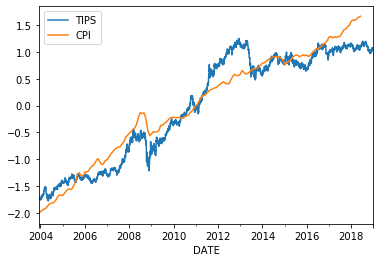

In [25]:
############################################################
# TIP analysis
############################################################
tip = df_prices['TIP'].dropna(axis=0)
tip = (tip + 1).cumprod()
tip = (tip - tip.mean())/tip.std()
tip.plot(label='TIPS')

cpi = df_econ['CPI'].dropna(axis=0)
cpi = cpi[cpi.index >= tip.index[0].asfreq('M')]
cpi = (cpi - cpi.mean())/cpi.std()
cpi.plot(label='CPI')

plt.legend()
plt.show()

{'VTI': 15, 'VEA': 6, 'VWO': 4, 'TLT': 25, 'ITE': 20, 'TIP': 15, 'DBC': 10, 'GLD': 5}
{'VTI': 60, 'TLT': 40}
{'VTI': 10.22820274, 'VEA': 2.80703365, 'VWO': 1.45880438, 'TLT': 12.1659097, 'ITE': 36.72334412, 'TIP': 24.69659242, 'DBC': 7.40656824, 'GLD': 4.51354474}
{'VTI': 12, 'VEA': 3.6, 'VWO': 2.4, 'TLT': 18, 'ITE': 30, 'TIP': 18, 'DBC': 9.6, 'GLD': 6}


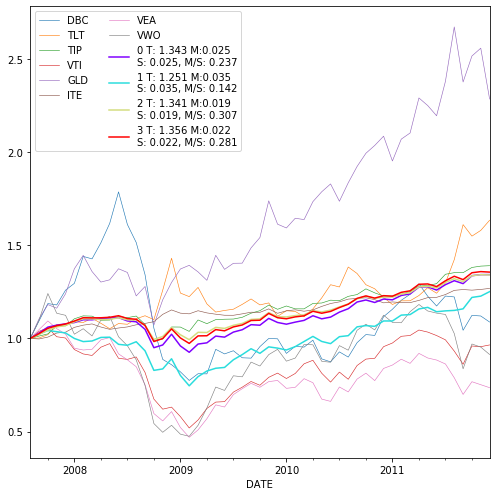

In [31]:
############################################################
# Backtest returns
############################################################
# analyze returns
allocs_for_analysis = [
    {'VTI': 15, 'VEA': 6, 'VWO': 4,
     'TLT': 25, 'ITE': 20,
     'TIP': 15,
     'DBC': 10, 'GLD': 5},
    # {'VTI': 9, 'VTV': 2, 'VOE': 2, 'VBR': 2,
    #  'VEA': 6, 'VWO': 4,
    #  'TLT': 25, 'ITE': 20,
    #  'TIP': 15,
    #  'DBC': 10, 'GLD': 5},
    {'VTI': 60,
     'TLT': 40},
    {'VTI': 10.22820274,
     'VEA': 2.80703365, 'VWO': 1.45880438,
     'TLT': 12.1659097, 'ITE': 36.72334412,
     'TIP': 24.69659242,
     'DBC': 7.40656824, 'GLD': 4.51354474},
    {'VTI': 12, 'VEA': 3.6, 'VWO': 2.4,
     'TLT': 18, 'ITE': 30,
     'TIP': 18,
     'DBC': 9.6, 'GLD':6}
]

# determine what ticks we need
unique_ticks = list(set([k for d in allocs_for_analysis for k in d.keys()]))
df_allprcs = df_prices_m[unique_ticks].dropna(axis=0, how='any')

# narrow by dates
df_allprcs = df_allprcs[(df_allprcs.index > '2000-01-01') & (df_allprcs.index < '2012-01-01')]
num_months = df_allprcs.shape[0]

# get cum rtn for each asset
df_allcum_rtns = df_allprcs / df_allprcs.iloc[0]

# plot cum rtn
fig, ax = plt.subplots(figsize=(7,7))
df_allcum_rtns.reset_index().plot(x='DATE', lw=0.6,  ax=ax)

# plot each strategy
palette = iter(plt.cm.rainbow(np.linspace(0, 1, len(allocs_for_analysis))))
for alloc_num, alloc in enumerate(allocs_for_analysis):
    # get ticks and % allocations for each tick
    ticks, pct_allocs = [], []
    for (k, v) in alloc.items():
        ticks.append(k)
        pct_allocs.append(v)
    # normalize % allocation
    pct_allocs = np.array(pct_allocs)/sum(pct_allocs)
    
    print('==================================================')
    print(alloc)
    df_prcs = df_allprcs[ticks]

    portfolio_value = [10**5]
    for i in range(num_months - 1):
        # calculate # shares per tick
        shares = (portfolio_value[-1] * pct_allocs / df_prcs.iloc[i]).values
        # calculate total portfolio value
        portfolio_value.append(sum(df_prcs.iloc[i + 1].values * shares))
    portfolio_value = np.array(portfolio_value)
    
    # calculate returns
    cum_rtns = pd.Series(portfolio_value / portfolio_value[0],
                     index=df_prcs.index)
    rtns = (portfolio_value[1:] / portfolio_value[:-1] - 1)
    label = ('{3} T: {4:.3f} M:{1:.3f} \nS: {1:.3f}, M/S: {2:.3f}'
             .format(rtns.mean(), rtns.std(),
                     rtns.mean()/rtns.std(),
                     alloc_num, cum_rtns[-1]))
    # plot returns
    cum_rtns.plot(label=label,
                  c=next(palette),
                  # cmap=plt.cm.get_cmap('tab10'),
                  ax=ax)
    
ax.legend(loc='best', ncol=2)    
fig.tight_layout()
plt.show()

In [34]:
#################### temporary stuff ####################
def get_lagged_df(df, i=1):
    if i == 0:
        return df
    return pd.DataFrame(df[:-i].values, index=df.index[i:], columns=df.columns)


def anchored_df(df, first_date=None, normalize=False):
    # remove all leading nans
    first_valid_indices = []
    for column in df:
        first_valid_indices.append(df[column].first_valid_index())
    earliest_date = max(first_valid_indices)
    if first_date:
        first_date = pd.Period(first_date, 'm')
        if first_date < earliest_date:
            print('First date {0} too early. Using earliest available date {1}'
                  .format(first_date, earliest_date))
            reduced_df = df[earliest_date:]
        reduced_df = df[first_date:]
    else:
        reduced_df = df[earliest_date:]

    print('Reduced rows from {0} to {1}'.format(df.shape[0],
                                                reduced_df.shape[0]))
    if normalize:
        # return normalized values
        return (reduced_df - reduced_df.values[0])/reduced_df.std().values
    else:
        return reduced_df - reduced_df.values[0]


df = df_prices_m.merge(df_econ, left_index=True, right_index=True)

temp = anchored_df(df[['PCY', 'rGDP', 'UNEMP', 'CPI']], normalize=True)
temp.plot(figsize=(10, 10))
plt.show()

KeyError: "['PCY'] not in index"

In [ ]:
df_prc_chng  = pd.DataFrame(df_stocks[1:].values/df_stocks[:-1].values-1,
                            columns=df_stocks.columns,
                            index=df_stocks.index[1:])

############################################################
# Correlation analysis
############################################################
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# correlation btw assets
# define corr variables
# Generate a mask for the upper triangle
D = df_prc_chng.shape[1]
mask = np.zeros((D, D), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.figure(figsize=(10, 10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_prc_chng.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# reduced correlations
D = df_prc_chng.shape[1]
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Set up the matplotlib figure
f = plt.figure(figsize=(10, 10))
for i in range(4):
    f.add_subplot(int('22'+str(i+1)))
    lag_df_econ = get_lagged_df(df_econ, i)
    df = pd.concat([df_prc_chng, lag_df_econ], axis=1, join='inner')
    # Draw the heatmap with the mask and correct aspect ratio
    ax = sns.heatmap(df.corr().iloc[:D, D:], cmap=cmap, vmax=.3, center=0,
                     square=True, linewidths=.5, cbar_kws={"shrink": .5})
    ax.set_title('Lag {0}'.format(i))
plt.legend()
plt.tight_layout()
plt.show()